In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.3 which is incompatible.


In [2]:
from unityagents import UnityEnvironment
import numpy as np
import importlib
import torch
import numpy as np

!curl -O https://raw.githubusercontent.com/udacity/workspaces-student-support/master/jupyter/workspace_utils.py
from workspace_utils import active_session

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")
print(env.brain_names)
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 2e-2              # for soft update of target parameters
LR_ACTOR = 2e-4         # learning rate of the actor 
LR_CRITIC = 2e-3        # learning rate of the critic
WEIGHT_DECAY = 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1554  100  1554    0     0   7895      0 --:--:-- --:--:-- --:--:--  9087


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


['TennisBrain']
Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


In [37]:
from collections import deque
import matplotlib.pyplot as plt
import maddpg
import ddpg_agent
importlib.reload(ddpg_agent)
importlib.reload(maddpg)
from maddpg import MultiAgent
%matplotlib inline

n_agents = 2
n_agents_in_agent = 1

args = [state_size, n_agents_in_agent, action_size, 40, 
                BUFFER_SIZE, BATCH_SIZE, GAMMA, TAU, LR_ACTOR, LR_CRITIC, WEIGHT_DECAY, device]

m_agent = MultiAgent(n_agents, args)

Episode: 	404 	Score: 	0.75 	Average Score: 	0.508
Environment solved in 404 episodes!	Average Score: 0.50


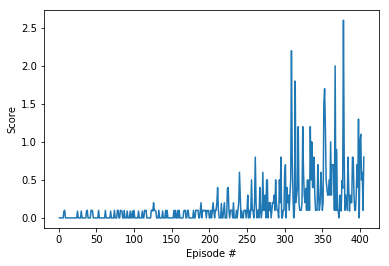

In [38]:
def ddpg_train():
    scores = []
    scores_window = deque(maxlen=100)
    n_episodes = 1000

    epsilon_start = 1.0
    epsilon = epsilon_start
    decay_rate = 0.003
    min_epsilon = 0.0
    
    for episode in range(n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]            # reset the environment
        states = env_info.vector_observations
        m_agent.reset()                                               # reset the agent noise
        score = np.zeros(n_agents)
        
        epsilon = epsilon - epsilon_start*decay_rate
        if epsilon < min_epsilon: epsilon = min_epsilon
        
        explore = np.random.choice(2, p=[1-epsilon, epsilon])
        
        while True:
            
            if explore:
                actions = np.random.randn(n_agents, action_size)
            else:
                actions = m_agent.act(states)
                actions = np.clip(actions, -1, 1)    
                actions = [action[0] for action in actions]
            
            env_info = env.step( actions )[brain_name]               # send the action to the environment                            
            next_states = env_info.vector_observations               # get the next state        
            rewards = env_info.rewards                               # get the reward        
            dones = env_info.local_done                              # see if episode has finished    
            #states = [[state] for state in states]
            dones = [[done] for done in dones]
            rewards = [[reward] for reward in rewards]
            m_agent.step(states, actions, rewards, next_states, dones)
            score += [reward[0] for reward in rewards]               # update the score
            states = next_states                                     # roll over the state to next time step        
                                                        
            if np.any( dones ):                                          # exit loop if episode finished        
                break                                        

        #agent.checkpoint()
        max_score = np.max(score)
        scores.append(max_score)
        scores_window.append(max_score)

        print('\rEpisode: \t{} \tScore: \t{:.2f} \tAverage Score: \t{:.2f}'.format(episode, np.mean(score), np.mean(scores_window)), end="")  
        
        if np.mean(scores_window) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
            [torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_id{}.pth'.format(i)) for i, agent in enumerate(m_agent.agents)]
            #torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break    

    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()    


# train the agent
with active_session():
    ddpg_train()

In [ ]:
for i in range(1):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    print(states)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
                 # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [ ]:
env.close()